<a href="https://colab.research.google.com/github/nihalsuri/thermal-anomaly-detection/blob/main/notebooks/thermal_anomaly_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uploading all necessary data when connected to host

In [ ]:
! gdown --id 1x4Os51uaMXDILTGo2Y_lOC9HU1jTnzi0
! gdown --id 1uxDV-sgzDUATHc5p8gW_gBKBsEVrz34X

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!unzip clutch_2.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Uploading data when connected to local runtime 

In [ ]:
annotations_path = 'C:/Users/Nihal/Desktop/thesis/dataset.csv'
dataset_path = 'C:/Users/Nihal/Desktop/thesis/clutch_2'

# Data preperation for training

In this section the following is done: 



*   Data is processed and arranged into respective **dataframes** 
*   **Custom dataset** class is created 
*   **Transforms** are done on the various datasets
*   **Dataloaders** are created for the purposes of iteration





## Import libraries

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from PIL import Image
from torchvision import transforms , models
from sklearn import metrics
from tabulate import tabulate
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name()
print(device_name)
print(device)

NVIDIA GeForce GTX 1660 Ti with Max-Q Design
cuda


## Split data into dataframes

In [ ]:
df = pd.read_csv(annotations_path)
train_df = df[df['dataset'].str.contains('train')]
test_df = df[df['dataset'].str.contains('test')]
val_df = df[df['dataset'].str.contains('val')]

## Custom Class 
Returns **image** and **label** for futher training

In [ ]:
class ClutchDataset(Dataset):

    def __init__(self, dataframe, root_dir, is_train, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 1])
        image1 = cv2.imread(img_name)
        image_norm = cv2.normalize(
            image1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        image = Image.fromarray(image_norm)
        label = torch.tensor(int(self.dataframe.iloc[idx, 2]))
         


        if self.transform:
            image = self.transform(image)

        return image, label

## Transforms on the datasets

In [ ]:
# Add transforms for train, test, val dataset
input_size_h = 512//16
input_size_w = 640//16
transform_train = transforms.Compose([
    transforms.Resize((input_size_h, input_size_w)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.RandomPerspective(),
    transforms.RandomRotation((1, 10))

])

transform_valid = transforms.Compose([
    transforms.Resize((input_size_h, input_size_w)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize((input_size_h, input_size_w)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

## Dataloaders and Iterator

Feature batch shape: torch.Size([128, 1, 32, 40])
Labels batch shape: torch.Size([128])


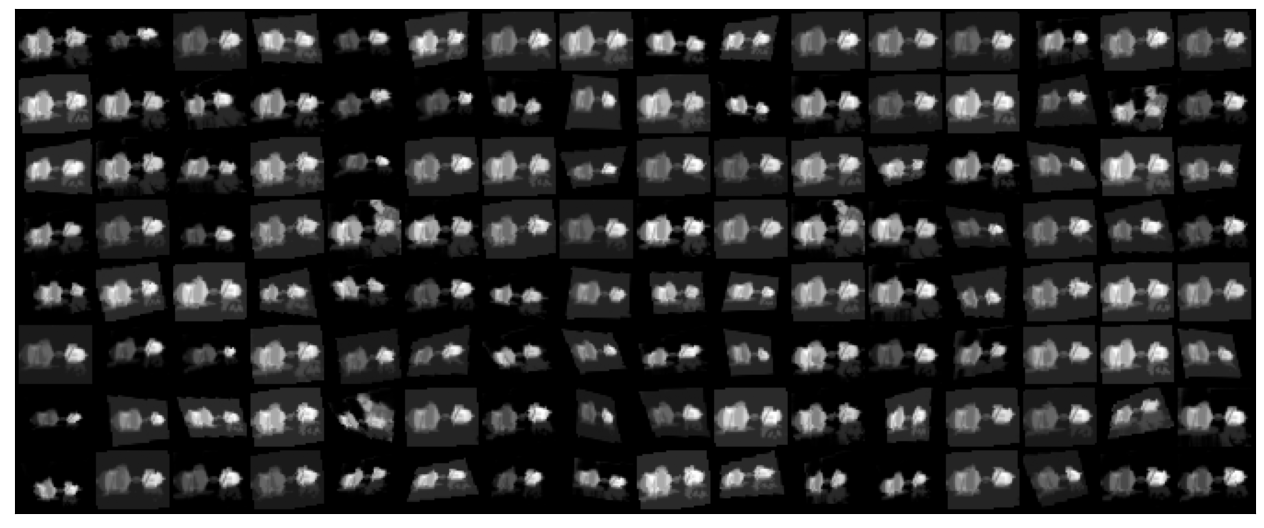

In [ ]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break



# dataloaders
train_dataset = ClutchDataset(
    train_df, root_dir=dataset_path, is_train=True, transform=transform_train)
val_dataset = ClutchDataset(val_df, root_dir=dataset_path,
                            is_train=False, transform=transform_valid)
test_dataset = ClutchDataset(
    test_df, root_dir=dataset_path, is_train=False, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = val_loader
dataloaders_dict['test'] = test_loader


# iteratre through dataloaders
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")
img = train_features[0].squeeze()
label = train_labels[0]

# convert image to APPEAR RGB
# rgb_train_features = np.repeat(train_features[..., np.newaxis], 3, -1)
# print(f"Feature batch shape: {rgb_train_features.shape}")
# train_features = rgb_train_features

# plt.imshow(img, cmap="gray")
# plt.axis('off')
# plt.show()
# print(f"Label: {label}")
show_batch(train_loader)






# Neural Networks
Various different NNs tested with the same dataset

In [ ]:
# # Create Fully connected network 
# class NN(nn.Module): 
#     def __init__(self, D_in, H1, D_out): 
#         super().__init__()
#         self.linear1 = nn.Linear(D_in, H1)
#         self.linear2 = nn.Linear(H1, D_out)
    
#     def forward(self, x): 
#         x = F.relu(self.linear1(x))
#         x = self.linear2(x)
#         return x 
    

# # Hyperparameters 
# input_size = input_size_h*input_size_w
# num_classes = 3 
# learning_rate = 0.001
# hidden_1 = 50


# # Initialize Network 
# model = NN(input_size, hidden_1 , num_classes)

# # Loss and optimizer 
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# epochs = 12
# running_loss_history = []
# running_corrects_history = []
# val_running_loss_history = []
# val_running_corrects_history = []


# for e in range(epochs):
  
#   running_loss = 0.0
#   running_corrects = 0.0
#   val_running_loss = 0.0 
#   val_running_corrects = 0.0

#   for inputs, labels in train_loader:
#     inputs = inputs.view(inputs.shape[0], -1)
#     outputs = model(inputs)
#     loss = criterion(outputs, labels) # finding out loss by comparing labels to outputs 
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
     
#     _, preds = torch.max(outputs, 1)
#     running_loss += loss.item()
#     running_corrects += torch.sum(preds == labels.data)   # Nr of correct predictions 

#   else:
#     with torch.no_grad(): 
#       for val_inputs, val_labels in val_loader:
#         val_inputs = val_inputs.view(val_inputs.shape[0], -1)
#         val_outputs = model(val_inputs)
#         val_loss = criterion(val_outputs, val_labels) # finding out loss by comparing labels to outputs
#         _, val_preds = torch.max(val_outputs, 1)
#         val_running_loss += val_loss.item()
#         val_running_corrects += torch.sum(val_preds == val_labels.data)   # Nr of correct predictions   

#     epoch_loss = running_loss/len(train_loader)
#     epoch_acc = running_corrects.float()/ len(train_loader)
#     running_loss_history.append(epoch_loss)
#     running_corrects_history.append(epoch_acc)
    

#     val_epoch_loss = val_running_loss/len(val_loader)
#     val_epoch_acc = val_running_corrects.float()/ len(val_loader)
#     val_running_loss_history.append(val_epoch_loss)
#     val_running_corrects_history.append(val_epoch_acc)

#     print('epoch : ', (e + 1))
#     print('training loss: {:.4f}, accuracy : {:.4f}'.format(epoch_loss, epoch_acc.item()))
#     print('validation loss: {:.4f}, validation accuracy : {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))






In [ ]:
# plt.plot(running_loss_history, label = 'training loss')
# plt.plot(val_running_loss_history, label = 'validation loss')
# plt.legend()

In [ ]:
# plt.plot(running_corrects_history, label = 'training accuracy')
# plt.plot(val_running_corrects_history, label = 'validation accuracy')
# plt.legend()

## CNN

### Training 

#### Hyper-parameters

In [ ]:
EPOCHS = 21
LEARNING_RATE = .001
PATH = "C:/Users/Nihal/Desktop/thesis/CNN_model.pt"

loss_val = []
loss_val_v = []
class_mapping = ['healthy', 'misalignment', 'rotor damage']


#### NN Class

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            # nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(2240, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, input):
        predictions = self.net(input)
        return predictions

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.net = nn.Sequential(
            
#             nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2,stride = 2),
        
#             nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels = 64 ,out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
            
#             nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),

#             # nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
#             # nn.ReLU(),
#             # nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
#             # nn.ReLU(),
#             # nn.MaxPool2d(2,2),

#             # nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
#             # nn.ReLU(),
#             # nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
#             # nn.ReLU(),
#             # nn.MaxPool2d(2,2),

#             # nn.Conv2d(in_channels = 1024, out_channels = 2048, kernel_size = 3, stride = 1, padding = 1),
#             # nn.ReLU(),
#             # nn.Conv2d(in_channels = 2048, out_channels = 2048, kernel_size = 3, stride = 1, padding = 1),
#             # nn.ReLU(),
#             # nn.MaxPool2d(2,2),
            
#             nn.Flatten(),
#             nn.Linear(2560, 64),
#             # nn.ReLU(),
#             # nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(64,3)
#         )
    
#     def forward(self, input):
#         predictions = self.net(input)
#         return predictions 


CNN()


CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2240, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=3, bias=True)
  )
)

#### Training per Epoch

Epoch 1
Loss: 1.0578423738479614

Epoch 2
Loss: 1.082607626914978

Epoch 3
Loss: 1.0530568361282349

Epoch 4
Loss: 1.174430012702942

Epoch 5
Loss: 0.9857419729232788

Epoch 6
Loss: 1.051751732826233

Epoch 7
Loss: 1.0785771608352661

Epoch 8
Loss: 0.9578383564949036

Epoch 9
Loss: 1.1791406869888306

Epoch 10
Loss: 0.950187087059021

Epoch 11
Loss: 0.8513404130935669

Epoch 12
Loss: 0.6969395279884338

Epoch 13
Loss: 0.5559912323951721

Epoch 14
Loss: 0.5645264387130737

Epoch 15
Loss: 0.40634292364120483

Epoch 16
Loss: 0.17963463068008423

Epoch 17
Loss: 0.5759570598602295

Epoch 18
Loss: 0.1255292296409607

Epoch 19
Loss: 0.1816261261701584

Epoch 20
Loss: 0.29914188385009766

Epoch 21
Loss: 0.42858582735061646

Training done!
Model trained and stored at CNN.pth


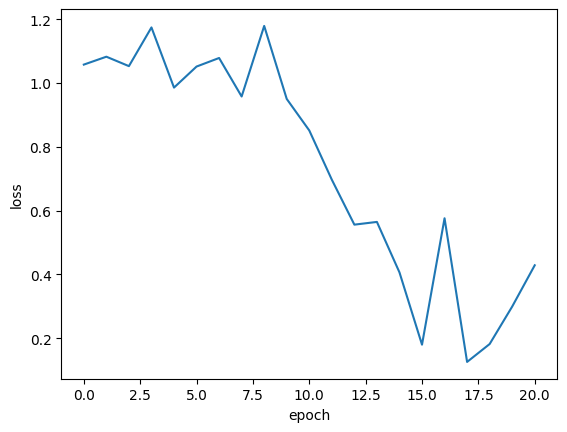

In [ ]:
def train_single_epoch(model, data_loader, lossfn, opt, dev):
    for inp, target in data_loader:
        inp, target = inp.to(dev), target.to(dev)

        opt.zero_grad()
        predictions = model(inp)
        loss = lossfn(predictions, target)
        loss.backward()
        opt.step()
    print(f'Loss: {loss.item()}')
    loss_val.append(loss.item())


def train(model, data_loader, lossfn, optim, dev, epochs):
    for i in range(epochs):
        print(f'Epoch {i + 1}')
        train_single_epoch(model, data_loader, lossfn, optim, dev)

        print()
    print('Training done!')



net = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, weight_decay=0.005, momentum=0.9)

train(net, train_loader, loss_fn, optimiser, device, EPOCHS)
torch.save(net.state_dict(), PATH)
print('Model trained and stored at CNN.pth')

plt.plot(loss_val)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# epochs = 10
# batch = 16
# running_loss_history = []
# running_corrects_history = []
# val_running_loss_history = []
# val_running_corrects_history = []

# complete_preds_train = []
# complete_labels_train = []
# complete_preds_val = []
# complete_labels_val = []


# for e in range(epochs):
  
#   running_loss = 0.0
#   running_corrects = 0.0
#   val_running_loss = 0.0 
#   val_running_corrects = 0.0

#   for inputs, labels in train_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     outputs = model_cnn(inputs)
#     loss = criterion(outputs, labels) # finding out loss by comparing labels to outputs 
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
     
#     _, preds = torch.max(outputs, 1)
#     running_loss += loss.item()
#     running_corrects += torch.sum(preds == labels.data)   # Nr of correct predictions
#     complete_preds_train.append(preds)
#     complete_labels_train.append(labels.data)

#   else:
#     with torch.no_grad(): 
#       for val_inputs, val_labels in val_loader:
#         val_inputs = val_inputs.to(device)
#         val_labels = val_labels.to(device)
#         val_outputs = model_cnn(val_inputs)
#         val_loss = criterion(val_outputs, val_labels) # finding out loss by comparing labels to outputs
#         _, val_preds = torch.max(val_outputs, 1)
#         val_running_loss += val_loss.item()
#         val_running_corrects += torch.sum(val_preds == val_labels.data)   # Nr of correct predictions 
#         complete_preds_val.append(val_preds)
#         complete_labels_val.append(val_labels.data)  

#     epoch_loss = ((running_loss/batch)*100)/len(train_loader)
#     epoch_acc = ((running_corrects.float()/batch)*100)/len(train_loader)
#     running_loss_history.append(epoch_loss)
#     running_corrects_history.append(epoch_acc)
    

#     val_epoch_loss = ((val_running_loss/batch)*100)/len(val_loader)
#     val_epoch_acc = ((val_running_corrects/batch)*100)/len(val_loader)
#     val_running_loss_history.append(val_epoch_loss)
#     val_running_corrects_history.append(val_epoch_acc)

#     print('epoch : ', (e + 1))
#     print('training loss: {:.4f}, accuracy : {:.4f}'.format(epoch_loss, epoch_acc.item()))
#     print('validation loss: {:.4f}, validation accuracy : {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

In [ ]:
# plt.plot(running_loss_history, label = 'training loss')
# plt.plot(val_running_loss_history, label = 'validation loss')
# plt.legend()

In [ ]:
# plt.plot(running_corrects_history, label = 'training accuracy')
# plt.plot(val_running_corrects_history, label = 'validation accuracy')
# plt.legend()

### Metrics

In [ ]:
def get_metrics(y_true, y_pred, class_mapping):

    total_predictions = [0, 0, 0]
    total_true = [0, 0, 0]

    cm = metrics.confusion_matrix(y_true, y_pred, labels=class_mapping)

    for i in range(3):
        for j in range(3):
            total_predictions[i] += cm[j][i]
            total_true[i] += cm[i][j]

    # recall and precision for each class
    r_h = cm[0][0] / total_predictions[0]
    r_m = cm[1][1] / total_predictions[1]
    r_r = cm[2][2] / total_predictions[2]
    p_h = cm[0][0] / total_true[0]
    p_m = cm[1][1] / total_true[1]
    p_r = cm[2][2] / total_true[2]

    # data for confusion matrix
    data = [["", class_mapping[0], class_mapping[1], class_mapping[2], "Total actual"],
            [class_mapping[0], cm[0][0], cm[0][1], cm[0][2], total_true[0]],
            [class_mapping[1], cm[1][0], cm[1][1], cm[1][2], total_true[1]],
            [class_mapping[2], cm[2][0], cm[2][1], cm[2][2], total_true[2]],
            ["Total predicted:", total_predictions[0], total_predictions[1], total_predictions[2], sum(total_true)]]

    # data for f1 score for each class
    data_f1 = [["Class", "F1-score"],
               ["Healthy", round((2 * p_h * r_h) / (p_h + r_h), 2)],
               ["Misalignment", round((2 * p_m * r_m) / (p_m + r_m), 2)],
               ["Rotor damage", round((2 * p_r * r_r) / (p_r + r_r), 2)]]

    # printing confusion matrix, f1 score table, recall and precision
    print(tabulate(data, tablefmt="simple_grid"))
    print()
    print(tabulate(data_f1, tablefmt="simple_grid"))
    print(f"\nRecall for healthy class: {round(r_h, 2)}")
    print(f"Recall for misalignment class: {round(r_m, 2)}")
    print(f"Recall for rotor damage class: {round(r_r, 2)}")
    print(f"\nPrecision for healthy class: {round(p_h, 2)}")
    print(f"Precision for misalignment class: {round(p_m, 2)}")
    print(f"Precision for rotor damage class: {round(p_r, 2)}")

### Predictions

#### Test 

In [ ]:
model_CNN = CNN()
model_CNN.load_state_dict(torch.load(PATH))


print('Test data: ')
y_true = []
y_pred = []

for i in range(len(test_dataset)):
    input, target = test_dataset[i][0], test_dataset[i][1]
    model_CNN.eval()
    with torch.no_grad():
        input = torch.unsqueeze(input, 0)
        predictions = model_CNN(input)
        predicted_index = predictions[0].argmax(0)

        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]

    y_true.append(expected)
    y_pred.append(predicted)

get_metrics(y_true, y_pred, class_mapping)

Test data: 
┌──────────────────┬─────────┬──────────────┬──────────────┬──────────────┐
│                  │ healthy │ misalignment │ rotor damage │ Total actual │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ healthy          │ 0       │ 0            │ 206          │ 206          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ misalignment     │ 0       │ 229          │ 0            │ 229          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ rotor damage     │ 0       │ 0            │ 216          │ 216          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ Total predicted: │ 0       │ 229          │ 422          │ 651          │
└──────────────────┴─────────┴──────────────┴──────────────┴──────────────┘

┌──────────────┬──────────┐
│ Class        │ F1-score │
├──────────────┼──────────┤
│ Healthy      │ nan      │
├──────────────┼──────────┤
│ Misalignm

c:\users\nihal\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  


#### Validation

In [ ]:
print('Valid data: ')
y_true = []
y_pred = []

for i in range(len(val_dataset)):
    input, target = val_dataset[i][0], val_dataset[i][1]
    model_CNN.eval()
    with torch.no_grad():
        input = torch.unsqueeze(input, 0)
        predictions = model_CNN(input)
        predicted_index = predictions[0].argmax(0)

        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]

    y_true.append(expected)
    y_pred.append(predicted)

get_metrics(y_true, y_pred, class_mapping)

Valid data: 
┌──────────────────┬─────────┬──────────────┬──────────────┬──────────────┐
│                  │ healthy │ misalignment │ rotor damage │ Total actual │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ healthy          │ 0       │ 0            │ 199          │ 199          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ misalignment     │ 0       │ 220          │ 0            │ 220          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ rotor damage     │ 0       │ 0            │ 229          │ 229          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ Total predicted: │ 0       │ 220          │ 428          │ 648          │
└──────────────────┴─────────┴──────────────┴──────────────┴──────────────┘

┌──────────────┬──────────┐
│ Class        │ F1-score │
├──────────────┼──────────┤
│ Healthy      │ nan      │
├──────────────┼──────────┤
│ Misalign

c:\users\nihal\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  


#### Training 

In [ ]:
print('Training data:')
y_true = []
y_pred = []

for i in range(len(train_dataset)):
    input, target = train_dataset[i][0], train_dataset[i][1]
    model_CNN.eval()
    with torch.no_grad():
        input = torch.unsqueeze(input, 0)
        predictions = model_CNN(input)
        predicted_index = predictions[0].argmax(0)

        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]

    y_true.append(expected)
    y_pred.append(predicted)

get_metrics(y_true, y_pred, class_mapping)

Training data:
┌──────────────────┬─────────┬──────────────┬──────────────┬──────────────┐
│                  │ healthy │ misalignment │ rotor damage │ Total actual │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ healthy          │ 444     │ 50           │ 63           │ 557          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ misalignment     │ 40      │ 940          │ 1            │ 981          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ rotor damage     │ 55      │ 23           │ 1087         │ 1165         │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ Total predicted: │ 539     │ 1013         │ 1151         │ 2703         │
└──────────────────┴─────────┴──────────────┴──────────────┴──────────────┘

┌──────────────┬──────────┐
│ Class        │ F1-score │
├──────────────┼──────────┤
│ Healthy      │ 0.81     │
├──────────────┼──────────┤
│ Misali